In [1]:
# Step 1 Import Libraries and Load Dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_fscore_support
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [31]:
#Step 2: Preview Dataset
df = pd.read_csv("Health Apple Dataset.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

# quick sanity
print("Date range:", df["date"].min().date(), "→", df["date"].max().date(), f"({len(df)} days)")
print("Columns:", list(df.columns))
df.head()


Date range: 2025-05-21 → 2025-09-17 (120 days)
Columns: ['date', 'steps', 'sleep_hours', 'resting_hr', 'active_energy_kcal', 'weight_kg']


,date,steps,sleep_hours,resting_hr,active_energy_kcal,weight_kg
0,2025-05-21,9398,7.37,60.7,407,70.76
1,2025-05-22,7184,7.23,62.7,379,70.75
2,2025-05-23,10373,7.57,62.5,408,70.73
3,2025-05-24,8642,7.94,63.1,370,70.72
4,2025-05-25,10332,7.36,59.8,455,70.71


                      date         steps  sleep_hours  resting_hr  \
count                  120    120.000000   120.000000  120.000000   
mean   2025-07-19 12:00:00   8635.983333     7.171917   62.616667   
min    2025-05-21 00:00:00   6002.000000     6.030000   57.000000   
25%    2025-06-19 18:00:00   7539.750000     6.977500   61.400000   
50%    2025-07-19 12:00:00   8591.500000     7.185000   62.500000   
75%    2025-08-18 06:00:00   9826.500000     7.402500   63.700000   
max    2025-09-17 00:00:00  13103.000000     8.070000   66.900000   
std                    NaN   1433.538251     0.381656    1.859174   

       active_energy_kcal   weight_kg  
count          120.000000  120.000000  
mean           349.150000   70.108250  
min            134.000000   69.490000  
25%            294.500000   69.777500  
50%            355.500000   70.090000  
75%            402.000000   70.432500  
max            538.000000   70.760000  
std             82.766214    0.373662  


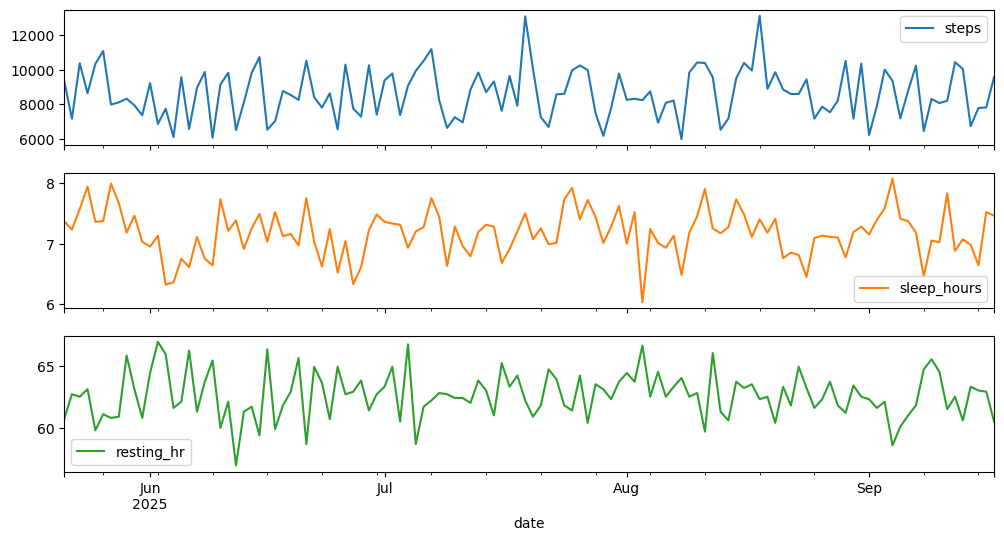

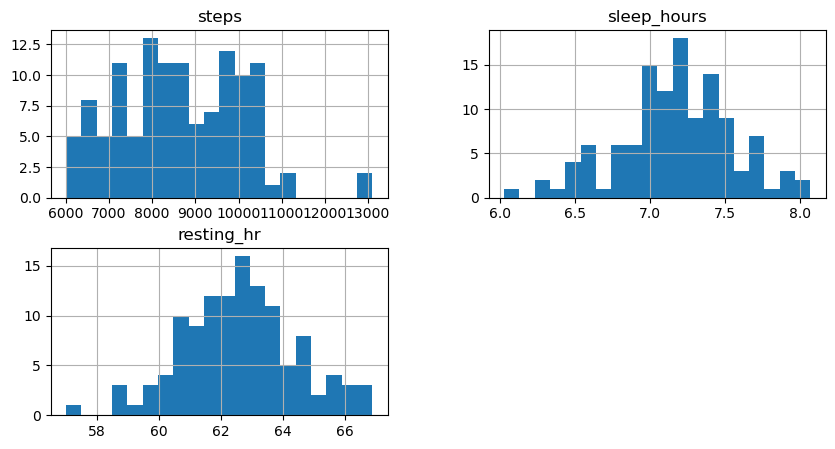

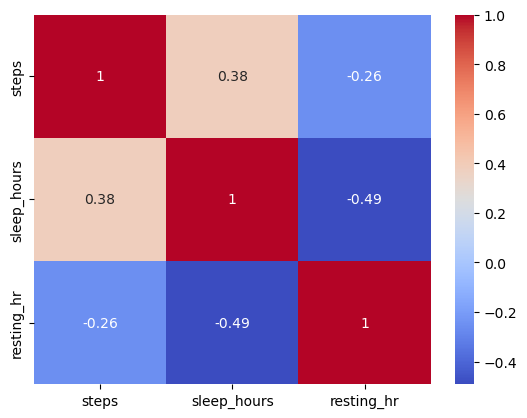

In [11]:
# Step 3: EDA and Visualize the Data 
# Summary
print(health_dataset.describe())

# Time series
health_dataset.set_index("date")[["steps","sleep_hours","resting_hr"]].plot(subplots=True, figsize=(12,6))
plt.show()

# Histograms
health_dataset[["steps","sleep_hours","resting_hr"]].hist(bins=20, figsize=(10,5))
plt.show()

# Correlation
sns.heatmap(health_dataset[["steps","sleep_hours","resting_hr"]].corr(), annot=True, cmap="coolwarm")
plt.show()


In [12]:
# Step 4:  Conditional probability
prob = (health_dataset[health_dataset["sleep_hours"] >= 7]["steps"] >= 10000).mean()
print("P(hit 10k steps | sleep >= 7h):", round(prob*100,2), "%")


P(hit 10k steps | sleep >= 7h): 22.73 %


In [26]:
# Step 5: Train and Test Model 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, precision_recall_fscore_support
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

MIN_TEST_DAYS = 30         # size of test window (days)
MAX_LOOKBACK  = 120        # max days to look back to find both classes in TEST
VAL_FRAC      = 0.20       # fraction of TRAIN reserved for validation
THRESH_GRID   = np.linspace(0.2, 0.8, 25)  # search space for decision threshold
USE_F1        = True       # True: maximize F1 on validation; False: maximize Youden's J

def find_time_split_with_both_classes(y, min_test=30, max_lookback=120):
    n = len(y)
    # Try last 30,45,60,... days as TEST until both classes present
    for span in [30, 45, 60, 75, 90, 105, 120]:
        if span > max_lookback or span >= max(n // 2, 30):
            continue
        split_idx = n - span
        test_vals = y.iloc[split_idx:]
        if test_vals.nunique() == 2:
            return split_idx
    # Fallback: 20%..40% tail until both classes present
    for frac in [0.2, 0.25, 0.3, 0.35, 0.4]:
        split_idx = int(n * (1 - frac))
        test_vals = y.iloc[split_idx:]
        if test_vals.nunique() == 2:
            return split_idx
    # Last resort: fixed min_test
    return max(0, n - min_test)

# --- Build time-aware split
n_samples = len(X)
if n_samples < 40:
    raise ValueError("Not enough rows to build a robust test set. Collect more days first.")

split_idx = find_time_split_with_both_classes(y, min_test=MIN_TEST_DAYS, max_lookback=MAX_LOOKBACK)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")
print("Train class balance:", y_train.value_counts().to_dict())
print("Test  class balance:", y_test.value_counts().to_dict())

# --- Pipeline: scaling + balanced logistic regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"))
])

pipe.fit(X_train, y_train)

# --- Tune decision threshold on a validation slice from the tail of TRAIN
v_start = int(len(X_train) * (1 - VAL_FRAC))
X_val, y_val = X_train.iloc[v_start:], y_train.iloc[v_start:]
p_val = pipe.predict_proba(X_val)[:, 1]

best_t, best_score = 0.5, -1
for t in THRESH_GRID:
    preds = (p_val >= t).astype(int)
    if USE_F1:
        _, _, f1, _ = precision_recall_fscore_support(y_val, preds, average="binary", zero_division=0)
        score = f1
    else:
        tp = ((preds == 1) & (y_val == 1)).sum()
        fn = ((preds == 0) & (y_val == 1)).sum()
        fp = ((preds == 1) & (y_val == 0)).sum()
        tn = ((preds == 0) & (y_val == 0)).sum()
        tpr = tp / (tp + fn + 1e-9)
        fpr = fp / (fp + tn + 1e-9)
        score = tpr - fpr
    if score > best_score:
        best_score, best_t = score, t

print(f"\nChosen decision threshold from validation: {best_t:.2f}  (score={best_score:.3f})")

# --- Evaluate on TEST
p_test = pipe.predict_proba(X_test)[:, 1]
y_pred = (p_test >= best_t).astype(int)

print("\n=== TEST METRICS ===")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
try:
    print("ROC-AUC  :", round(roc_auc_score(y_test, p_test), 3))
except ValueError:
    print("ROC-AUC  : (undefined – only one class present in y_test)")

print("\nClassification report (zero_division=0):")
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   index=["true_0","true_1"], columns=["pred_0","pred_1"]))

# Keep references for the next cell
clf = pipe
best_threshold = best_t



Train size: 86 | Test size: 30
Train class balance: {0: 72, 1: 14}
Test  class balance: {0: 24, 1: 6}

Chosen decision threshold from validation: 0.65  (score=0.667)

=== TEST METRICS ===
Accuracy : 0.667
ROC-AUC  : 0.479

Classification report (zero_division=0):
              precision    recall  f1-score   support

           0      0.818     0.750     0.783        24
           1      0.250     0.333     0.286         6

    accuracy                          0.667        30
   macro avg      0.534     0.542     0.534        30
weighted avg      0.705     0.667     0.683        30


Confusion matrix (rows=true, cols=pred):
        pred_0  pred_1
true_0      18       6
true_1       4       2


In [28]:
# Step 6: Recommendations 
today_X = X.iloc[[-1]]

# Get probability safely as a scalar
p_today = clf.predict_proba(today_X)[:, 1][0]     # option 1
# OR
# p_today = clf.predict_proba(today_X)[:, 1].item()   # option 2

t = best_threshold  # tuned threshold from validation
hit_tomorrow = int(p_today >= t)

print(f"Chance you’ll hit 10k steps tomorrow: {p_today:.0%}  (threshold={t:.2f})")



Chance you’ll hit 10k steps tomorrow: 49%  (threshold=0.65)
